<a href="https://colab.research.google.com/github/mwelland/Wyrm/blob/main/demos/Allen_Cahn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstration of Allen-Cahn phase-field model

In [1]:
#Install Firedrake if not installed
try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *


from firedrake.pyplot import tripcolor
import matplotlib.pyplot as plt

--2025-06-05 19:42:34--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-06-05 19:42:34 (41.1 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a51d

In [2]:
# Parameters
interface_width = .01
interface_energy = 1
interface_mobility = 50

dt = Constant(1e-1)
t0 = 0
t_final = 1

In [3]:
# Create a mesh with resolution of approximately the interface width
mesh_resolution = int(1/(2*interface_width))
mesh = UnitSquareMesh(mesh_resolution, mesh_resolution)

x = SpatialCoordinate(mesh)

In [4]:
# Define the function space and instanciate the function and test_functions
V = FunctionSpace(mesh, "CG", 1, name="phase")

phase = Function(V)
phase_old = Function(V) # Used to store previous time step
test_phase = TestFunction(V)

In [14]:
# Phase field functions
g_phase = phase**2*(1-phase)**2

dg_phase = 2*phase*(1-3*phase+2*phase**2)
driving_force = 3*(-interface_width**2*inner(grad(test_phase),grad(phase)) + dg_phase*test_phase)


driving_force = derivative(interface_energy*interface_area, phase, test_phase)
interface_area = 3*( interface_width**2*inner(grad(phase),grad(phase)) + g_phase)

F_phase_interface = -interface_mobility*driving_force

F = (phase-phase_old)*test_phase - dt*F_phase_interface
F = F*dx

In [16]:
# Set initial condition to be a circle in the middle of the mesh
t = t0

def tanh_profile(x):
  return .5*(1.-tanh(x/(2.*interface_width)))

def bubble(r, centre):
  c = as_vector(centre)
  d = sqrt(inner(x-c, x-c))
  return tanh_profile(d - r)

bub1 = bubble(r = .3, centre = [.5,.5])

phase.interpolate(bub1)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7c6ee98766d0>, FiniteElement('Lagrange', triangle, 1), name='phase'), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0)), 3)

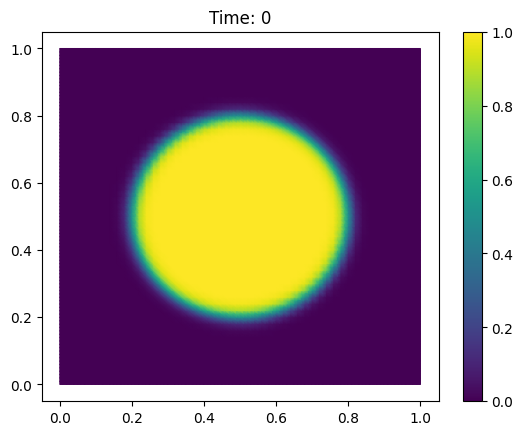

In [17]:
# Use tripcolor and set vmin and vmax for the color mapping
def plot_phase(t):
  fig, axes = plt.subplots()
  colors = tripcolor(phase, axes=axes, vmin=0, vmax=1)
  axes.set_title(f"Time: {round(t,1)}")
  fig.colorbar(colors)
  plt.show()

plot_phase(t)

In [18]:
while t<t_final:
    phase_old.assign(phase)
    t += dt(0)
    print(f"Current Time: {round(t,2):.2e}")

    solve(F == 0, phase, solver_parameters={"ksp_type": "preonly", "pc_type": "lu"})
    plot_phase(t)

Current Time: 1.00e-01


ConvergenceError: Nonlinear solve failed to converge after 2 nonlinear iterations.
Reason:
   DIVERGED_DTOL